# Scenario of admixture for tests of methods

One population.<br>
Admixture at time T.<br>
Ancient samples taken before and after admixture.<br>
Modern samples.<br>


Remove comments in cells below to also simulate the "hidden population" that admixed with the population above.

In [1]:
import msprime
import allel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
Ne = 15000
nbPops = 2
nbM = 10
nbA = 3
M = 1
m = M/(4*Ne)
T = 500
ages = [0, 100, 200, 300, 400, 600, 700, 800, 900]
# ages2 = [100, 200, 300, 400, 600, 700, 800, 900]

population_configurations=[
        msprime.PopulationConfiguration(initial_size=Ne),
        msprime.PopulationConfiguration(initial_size=Ne)]
demographic_events=[
        msprime.MassMigration(T, source=0, dest=1, proportion=0.2),
        msprime.MigrationRateChange(T, rate=m)]
samples = [msprime.Sample(0,0) for i in np.arange(2*nbM)]
for i in ages[1:]:
    samples += [msprime.Sample(0,i) for j in np.arange(2*nbA)]
# for i in ages2:
#     samples += [msprime.Sample(1,i) for j in np.arange(2*nbA)]

In [3]:
def run_simu(num_replicates, nbM, nbA, population_configurations, demographic_events, samples, nb_ancient_ages):
    """
    Runs num_replicates simulations, each one generating a very small number of SNPs. All these mutations are
    pooled in order get thousands of independent SNPs.
    """
    s = 0
    replicates = msprime.simulate(length= 80,
                                  mutation_rate=1e-8, recombination_rate=1e-8,
                                  samples = samples,
                                  num_replicates=num_replicates,
                                  population_configurations = population_configurations,
                                  demographic_events=demographic_events)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbM + nbA*nb_ancient_ages,2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

In [4]:
g = allel.model.GenotypeArray(run_simu(100000, nbM, nbA, population_configurations,
                                       demographic_events, samples, -1 + len(ages) ))#+ len(ages2)))
g

<GenotypeArray shape=(48720, 34, 2) dtype=int8>
0/0 0/0 0/0 0/0 1/0 ... 0/1 1/0 1/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 1/0 0/1 0/0 ... 1/0 1/0 1/0 0/1 1/1
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/1 0/1 1/0 1/1 0/0 ... 0/0 1/1 0/1 0/1 0/0
0/1 1/1 1/0 0/0 0/1 ... 1/0 1/1 0/0 0/1 1/1

In [5]:
gn = g.to_n_alt()[:]

# PCA
coords, model = allel.stats.pca(gn, scaler=None)
coords.shape

times = list(map(str, ages))
# times += list(map(str, ages2))
# times = [str(0)] * nbM
# ages2 = [str(age) for age in ages]
# times += ages2
# times += ['100c', '200c', '300c', '400c', '600c', '700c', '800c']
palette = sns.color_palette("hls", len(times))
i = 0
type_color = {}
for t in times:
    type_color[t] = palette[i]
    i += 1

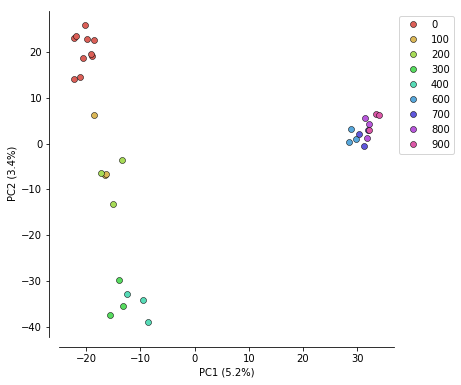

In [6]:
def plot_pca_coords(coords, model, pc1, pc2, ax):
    i = 0
    # modern samples
    x = coords[0:nbM, pc1]
    y = coords[0:nbM, pc2]
    ax.plot(x, y, marker='o', linestyle=' ', label=str(0), color=type_color[str(0)], markersize=6, mec='k', mew=.5)
    i += nbM
    # ancient samples
    for a in ages[1:]:
        x = coords[i:i+nbA, pc1]
        y = coords[i:i+nbA, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=str(a),
                color=type_color[str(a)], markersize=6, mec='k', mew=.5)
        i += nbA
#     for a in ages2:
#         x = coords[i:i+nbA, pc1]
#         y = coords[i:i+nbA, pc2]
#         ax.plot(x, y, marker='v', linestyle=' ', label=str(a),
#                 color=type_color[str(a)], markersize=6, mec='k', mew=.5)
#         i += nbA
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

Text(0.5,1.02,'PC maps')

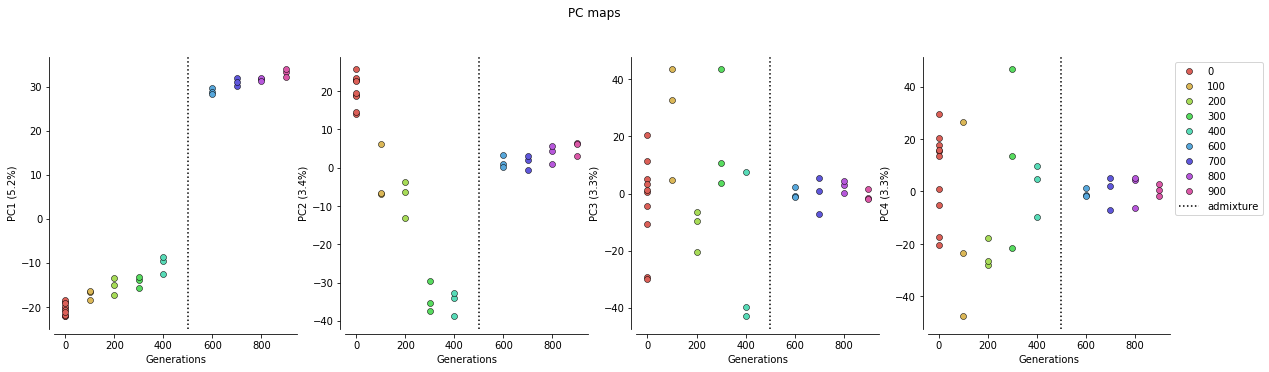

In [7]:
def plot_PC_maps(coords, model, pc, ax):
    """
    Plots each PC element against the sample number.
    """
    sns.despine(ax=ax, offset=5)
    # modern samples
    y = coords[0:nbM, pc]
    x = np.zeros(len(y))
    ax.plot(x, y, marker='o', linestyle=' ', label=str(0), color=type_color[str(0)], markersize=6, mec='k', mew=.5)
    i = nbM
    l = nbM
    # ancient samples
    for a in ages[1:]:
        y = coords[i:i+nbA, pc]
        x = np.ones(len(y))
        ax.plot(a*x, y, marker='o', linestyle=' ', label=a, color=type_color[str(a)], markersize=6, mec='k', mew=.5)
        i += nbA
#     for a in ages2:
#         y = coords[i:i+nbA, pc]
#         x = np.ones(len(y))
#         ax.plot(a*x, y, marker='v', linestyle=' ', label=a, color=type_color[str(a)], markersize=6, mec='k', mew=.5)
#         i += nbA
    ax.set_ylabel('PC%s (%.1f%%)' % (pc+1, model.explained_variance_ratio_[pc]*100))
    ax.axvline(T, linestyle=':', color="black", label="admixture")
    ax.set_xlabel('Generations')
    
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1,4,1)
plot_PC_maps(coords, model, 0, ax)
ax = fig.add_subplot(1,4,2)
plot_PC_maps(coords, model, 1, ax)
ax = fig.add_subplot(1,4,3)
plot_PC_maps(coords, model, 2, ax)
ax = fig.add_subplot(1,4,4)
plot_PC_maps(coords, model, 3, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
fig.suptitle('PC maps', y=1.02)

In [8]:
ages_onePop = []
for a in [0]:
    ages_onePop += [a for i in np.arange(nbM)]
for a in ages[1:]:
    ages_onePop += [a for i in np.arange(nbA)]
# for a in ages2:
#     ages_onePop += [a for i in np.arange(nbA)]
with open("temp.txt", "w") as f:
    i = 0
    for ind in np.arange(gn.shape[1]):
        f.write("%s\t" % ages_onePop[i])
        for var in np.arange(gn.shape[0]):
            if var != gn.shape[0]-1:
                f.write("%s\t" % gn[var, ind])
            else:
                f.write("%s\n" % gn[var, ind])
        i += 1